In [72]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.13.0


In [96]:
!pip install git+https://github.com/tensorflow/docs

'pip' is not recognized as an internal or external command,
operable program or batch file.


In [97]:


import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots


In [75]:
from IPython import display
from matplotlib import pyplot as plt

import numpy as np
import pathlib
import shutil
import tempfile

In [76]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [77]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')


In [78]:
FEATURES = 28

In [79]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")



In [80]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

In [81]:
packed_ds = ds.batch(1000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


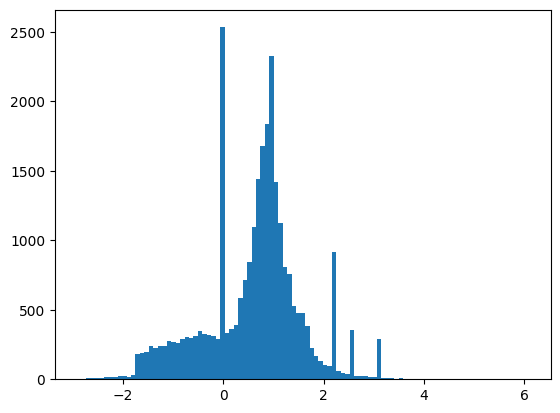

In [82]:
for features, label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins=101)

In [83]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE


In [84]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [85]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [86]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [87]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)


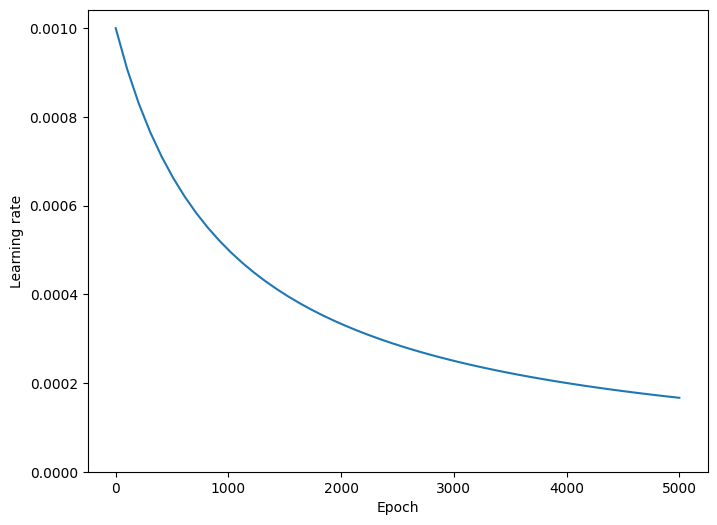

In [88]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize=(8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning rate')

In [89]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
        tf.keras.callbacks.TensorBoard(logdir/name)
    ]

In [90]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.metrics.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history


In [91]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])


In [92]:
size_histories = {}


In [98]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 16)                464       
                                                                 
 dense_15 (Dense)            (None, 1)                 17        
                                                                 
Total params: 481 (1.88 KB)
Trainable params: 481 (1.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accuracy:0.5010,  binary_crossentropy:0.8136,  loss:0.8136,  val_accuracy:0.4860,  val_binary_crossentropy:0.7944,  val_loss:0.7944,  
....................................................................................................
Epoch: 100, accuracy:0.6045,  binary_crossentropy:0.6255,  loss:0.6255,  val_accuracy:0.5680,  val_binary_crossentropy:0.6291,  val_loss:0.6291,  
..........................

(0.5, 0.7)

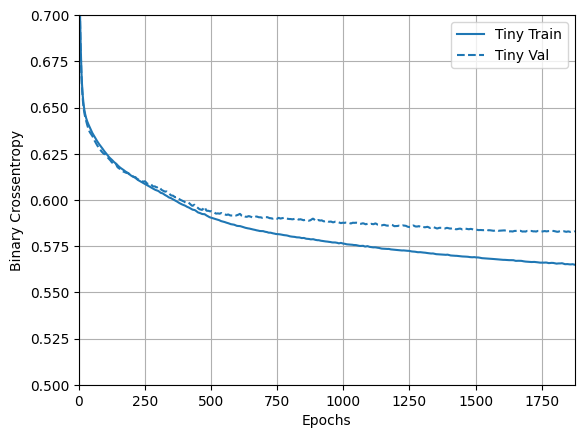

In [99]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

In [100]:
small_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [101]:
size_histories['small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 16)                464       
                                                                 
 dense_17 (Dense)            (None, 16)                272       
                                                                 
 dense_18 (Dense)            (None, 1)                 17        
                                                                 
Total params: 753 (2.94 KB)
Trainable params: 753 (2.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accuracy:0.4986,  binary_crossentropy:0.7653,  loss:0.7653,  val_accuracy:0.4820,  val_binary_crossentropy:0.7302,  val_loss:0.7302,  
....................................................................................................
Epoch: 100, accuracy:0.6256,  binary_cros

In [102]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

In [103]:
size_histories['medium'] = compile_and_fit(medium_model, 'sizes/Medium')

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 64)                1856      
                                                                 
 dense_20 (Dense)            (None, 64)                4160      
                                                                 
 dense_21 (Dense)            (None, 64)                4160      
                                                                 
 dense_22 (Dense)            (None, 1)                 65        
                                                                 
Total params: 10241 (40.00 KB)
Trainable params: 10241 (40.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accuracy:0.4878,  binary_crossentropy:0.7028,  loss:0.7028,  val_accuracy:0.4890,  val_binary_crossentropy:0.6788,  val_loss:0.6788,  
....

In [104]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

In [105]:
size_histories['large'] = compile_and_fit(large_model, 'sizes/Large')

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 512)               14848     
                                                                 
 dense_24 (Dense)            (None, 512)               262656    
                                                                 
 dense_25 (Dense)            (None, 512)               262656    
                                                                 
 dense_26 (Dense)            (None, 512)               262656    
                                                                 
 dense_27 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803329 (3.06 MB)
Trainable params: 803329 (3.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accura

Text(0.5, 0, 'Epochs [Log Scale]')

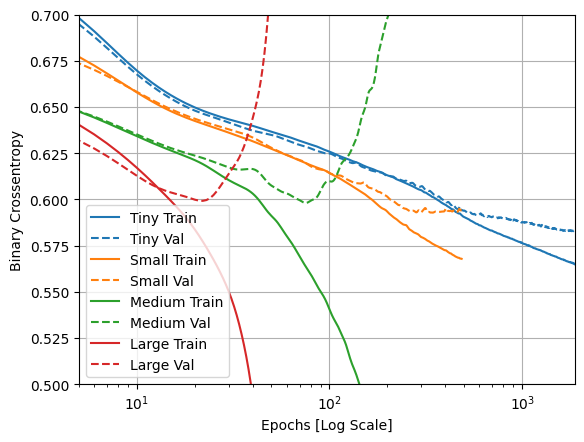

In [106]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5,max(plt.xlim())])
plt.ylim([0.5,0.7])
plt.xlabel("Epochs [Log Scale]")

In [109]:
%load_ext tensorboard
# %reload_ext tensorboard

In [111]:
%tensorboard --logdir {logdir}/sizes

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.